In [62]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [32]:
%matplotlib inline

##### This part is data preparation. This takes a couple of minutes to run. This part can be conveniently skipped without losing the flow of the problem

In [7]:
#Reading in the data

fraud_data = pd.read_csv('fraud_data.csv')
ip_address = pd.read_csv('IpAddress_to_Country.csv')
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [8]:
ip_address.head(5)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [9]:
#Comparing both the tables

len(fraud_data) == len(ip_address)

False

In [10]:
fraud_data.shape

(151112, 11)

In [11]:
ip_address.shape

(138846, 3)

In [42]:
country = len(fraud_data) * [0]

for ind, row in fraud_data.iterrows():
    temp = ip_address[(ip_address['lower_bound_ip_address'] < row['ip_address']) & 
           (ip_address['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

fraud_data['country'] = country

In [43]:
fraud_data.to_csv('full_data.csv')

##### Beginning of the problem

In [33]:
data = pd.read_csv('full_data.csv')
data = data.drop('Unnamed: 0', axis = 1)

In [34]:
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [36]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


#### Quick Insights

From the above table, it can be seen that the averge purchase value is around 36 with the median around 35. This indicates    that the purchase value is pretty evenly distributed. 

Minimum age as entered by the user is 18 with a max of 76 and an average 33 and median of 33. This indicates that the site consists of a lot of young users

The percentage of fraudulent activity is around 9%. This is slightly on the high end and needs to be looked into. 

In [37]:
#Converting signup time and purchase time to datetime objects

data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [38]:
data['source'].describe()

count     151112
unique         3
top          SEO
freq       60615
Name: source, dtype: object

In [39]:
data['country'].describe()

count            151112
unique              182
top       United States
freq              58049
Name: country, dtype: object

In [40]:
#Let's perform feature engineering
#Creating more powerful variables

# 1.Difference between signup time and purchase time
# 2.Different user id's using the same device could be an indication of a fake transaction
# 3.Different user id's from the same IP address could be a fake transaction

In [41]:
#Difference between signup time and purchase time
data['diff_time'] = (data['purchase_time'] - data['signup_time'])/np.timedelta64(1, 's')

In [42]:
#Different user id's using the same device
device_user_count = len(data) * [0]
device_count = data.groupby('device_id')['user_id'].count()
device_user_count = device_count[data['device_id']]
device_user_count = device_user_count.reset_index().drop('device_id', axis = 1)
device_user_count.columns = ['device_user_count']

In [43]:
data = pd.concat([data, device_user_count], axis = 1)

In [44]:
#Number of users' using a given ip address

ip_count = data.groupby('ip_address')['user_id'].count()
ip_count = ip_count[data['ip_address']].reset_index().drop('ip_address', axis = 1)
ip_count.columns = ['ip_count']
data = pd.concat([data, ip_count], axis = 1)

In [45]:
#Keeping only the top 50 countries
#Replacing everything else with 'Other'

temp = data.groupby('country')[['user_id']].count().sort_values('user_id', ascending = False)
temp = temp.iloc[:50,:].loc[data['country']].reset_index()
temp.loc[temp.isnull().any(axis = 1), 'country'] = 'other'
temp.loc[temp['country'] == '0','country'] = 'other'
temp = temp.drop('user_id', axis = 1)
temp.columns = ['country_revised']
data = pd.concat([data, temp], axis = 1)
data = data.drop('country', axis = 1)

In [46]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,diff_time,device_user_count,ip_count,country_revised
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4506682.0,1,1,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944.0,1,1,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1.0,12,12,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085.0,1,1,other
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461.0,1,1,United States


#### Building a Machine Learning Model

In [47]:
#Response Variable
y = data['class']

In [48]:
#Predictors
data = data.drop(['user_id', 'signup_time','purchase_time','class'], axis = 1)

In [49]:
X = data

In [50]:
X.isnull().sum()

purchase_value       0
device_id            0
source               0
browser              0
sex                  0
age                  0
ip_address           0
diff_time            0
device_user_count    0
ip_count             0
country_revised      0
dtype: int64

In [51]:
#Label Encoding string variables
lb = LabelEncoder()
X['device_id'] = lb.fit_transform(X['device_id'])
X['source'] = lb.fit_transform(X['source'])
X['browser'] = lb.fit_transform(X['browser'])
X['sex'] = lb.fit_transform(X['sex'])
X['country_revised'] = lb.fit_transform(X['country_revised'])

In [52]:
#Splitting data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [53]:
#Creating a pipeline
pipeline = Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])

In [54]:
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,
                                    min_samples_split= 3, oob_score= True)

In [55]:
clf_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [56]:
preds = clf_forest.predict(X_test)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [57]:
print classification_report(y_test, preds)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     34255
          1       0.99      0.54      0.70      3523

avg / total       0.96      0.96      0.95     37778



In [58]:
#Variable importance
clf_forest.feature_importances_

array([ 0.06008194,  0.07852501,  0.01169633,  0.01721329,  0.00652679,
        0.05213654,  0.08000387,  0.40200384,  0.15667323,  0.10583056,
        0.02930859])

In [59]:
#Features used are 
data.columns.values[:-1]

array(['purchase_value', 'device_id', 'source', 'browser', 'sex', 'age',
       'ip_address', 'diff_time', 'device_user_count', 'ip_count'], dtype=object)

In [60]:
#out of box score
clf_forest.oob_score_

0.95499144122681634

In [61]:
#Some quick insights
#From the above, it is very clear that we are able to predict fraud with a precision of 98% and a recall of 54%
#This implies of all the times we predicted fraud, we were right 98% of the time
#Similarly, of all the fraud that has taken place, we were able to correctly identify only 54% of it. 
#It is clear that we need to improve our recall rate even if it reduces the precision
#This is act of balancing false positives and false negatives
#A false positive would imply more checks on a potentially non -fraudulent customer
#A false negative would imply an act of fraud going undetected. 
#Thus we need to decrease false negatives, even if it is at the cost of false positives.
#This would automatically improve our recall/sensitivity score

In [81]:
#ROC analysis

prob_score = clf_forest.predict_proba(X_test)
prob_score = DataFrame(prob_score).iloc[:,0]

In [104]:
fpr,tpr,thresholds = roc_curve(y_test, prob_score)
#auc = auc(fpr,tpr)

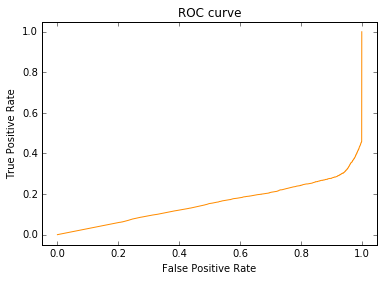

In [105]:
#Plotting the ROC curve
plt.plot(fpr,tpr, color = 'darkorange')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [94]:
tpr

array([ 0.        ,  0.06074368,  0.06074368, ...,  0.52284984,
        0.52398524,  1.        ])

In [95]:
fpr

array([ 0.        ,  0.20426215,  0.20434973, ...,  1.        ,
        1.        ,  1.        ])